# Obsah

> ## Úvod

> ## Knižnice

> ## Dataset

> ## Chýbajúce hodnoty

>> ### Zjednotenie formátov dát

>> ### Odvodenie chýbajúcich hodnôt po riadkoch

>> ### Doplnenie chýbajúcich hodnôt po stĺpcoch

> ## Vychýlené hodnoty

> ## Normalizácia údajov

> ## Transformácia numerických atribútov na kategorické

> ## Transformacia kategorických údajov na numerické

> ## Vytváranie atribútov kombinovanim

> ## Zdroje

## Doležité parametre
DecisionTreeClassifier(
criterion

max_depth=None

min_samples_leaf - počet pozorovani vo vyslednej podmnozine

class_weight=None

# Úvod
Na základe identifikovaných problémov v dátach a návrhu ich riešenia v predchádzajúcej fáze treba zrealizovať predspracovanie. Výsledkom by mala byť upravená dátová sada (vo formáte ​csv​) vo vhodnom tvare pre zvolený algoritmus strojového učenia (v našom prípade rozhodovacie stromy​). Zároveň, keďže predspracovaním sa mohol zmeniť tvar a charakteristiky dát (počet atribútov, distribúcie hodnôt a pod.), treba znovu zrealizovať podstatné časti prieskumnej analýzy, pričom v tejto fáze je potrebné zamerať sa aj na vzťahy medzi jednotlivými atribútmi.

# Knižnice

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from sklearn import preprocessing
import math
import datetime as dt

#regular expression
import re

#Nastavenie rozmerov zobrazovaných grafov
plt.rcParams['figure.figsize'] = 9, 6
from IPython.display import Image

# Dataset

In [2]:
file_path = "data/zadanie4/train.csv"
# Načítame si súbor s datasetom so separátom ',' a ako index nastavime prvý stĺpec
train_data = pd.read_csv(file_path, sep=',', index_col=0)
# Pomenujeme si index
train_data.index.name = 'id'
#train_data.info()

In [3]:
file_path = "data/zadanie4/test.csv"
# Načítame si súbor s datasetom so separátom ',' a ako index nastavime prvý stĺpec
test_data = pd.read_csv(file_path, sep=',', index_col=0)
# Pomenujeme si index
test_data.index.name = 'id'
#test_data.info()

In [4]:
#Aby sme mohli pracovat 
data = train_data
#data = test_data

In [5]:
def fixWierdCharsInString(string):
    if isinstance(string, float) or isinstance(string, int):
        return string
    if not isinstance(string, str): 
        return string
    if pd.isna(string) or string == '?' or string == '??':
        return np.nan
    #ocisti string od bielych znakov a regex: nahrad znaky [ -], za _
    return re.sub('[ -]','_', str.strip(string).upper())

In [6]:
#Zjednotenie názvov stĺpcov
data = data.rename(columns=fixWierdCharsInString)
data.columns

Index(['AGE', 'SEX', 'ON_THYROXINE', 'QUERY_ON_THYROXINE',
       'ON_ANTITHYROID_MEDICATION', 'SICK', 'PREGNANT', 'THYROID_SURGERY',
       'I131_TREATMENT', 'QUERY_HYPOTHYROID', 'QUERY_HYPERTHYROID', 'LITHIUM',
       'GOITRE', 'TUMOR', 'HYPOPITUITARY', 'PSYCH', 'TSH_MEASURED', 'TSH',
       'T3_MEASURED', 'T3', 'TT4_MEASURED', 'TT4', 'T4U_MEASURED', 'T4U',
       'FTI_MEASURED', 'FTI', 'TBG_MEASURED', 'TBG', 'REFERRAL_SOURCE',
       'CLASS', 'FNLWGT', 'EDUCATION', 'EDUCATION_NUM', 'RELATIONSHIP',
       'CAPITAL_GAIN', 'CAPITAL_LOSS', 'HOURS_PER_WEEK', 'DATE_OF_BIRTH',
       'PERSONAL_INFO'],
      dtype='object')

# Zjednotenie formátov dát

In [7]:
def checkAllObjectType(data):
    #help(data.select_dtypes)
    #Selektneme si vsetky atribúty, ktoré majú nejasný dátový
    for col_name in data.select_dtypes('object'):
        #Spočítame si pre každý "kategorický" atribút počet jeho jedinečných hodnôt
        print(col_name,":",data[col_name].nunique())  


In [8]:
checkAllObjectType(data)

SEX : 3
ON_THYROXINE : 6
QUERY_ON_THYROXINE : 2
ON_ANTITHYROID_MEDICATION : 2
SICK : 2
PREGNANT : 2
THYROID_SURGERY : 2
I131_TREATMENT : 2
QUERY_HYPOTHYROID : 2
QUERY_HYPERTHYROID : 2
LITHIUM : 2
GOITRE : 2
TUMOR : 2
HYPOPITUITARY : 2
PSYCH : 2
TSH_MEASURED : 2
T3_MEASURED : 2
TT4_MEASURED : 2
T4U_MEASURED : 2
FTI_MEASURED : 2
FTI : 210
TBG_MEASURED : 1
TBG : 1
REFERRAL_SOURCE : 5
CLASS : 2800
EDUCATION : 16
RELATIONSHIP : 9
DATE_OF_BIRTH : 2456
PERSONAL_INFO : 700


Pre všetky vyššie atribúty nastavíme správny formát dát a prekonvertujeme na číselnú reprezentáciu, kvôli neskoršej klasifikácií.

In [9]:
#help(data.to_numeric)
#If ‘coerce’, then invalid parsing will be set as NaN
#FTI prekonvertujeme na čísla
column=fixWierdCharsInString('FTI')
data[column] = pd.to_numeric(data[column], errors='coerce')
data[column].describe()

count    2505.000000
mean      110.787984
std        32.883986
min         2.000000
25%        93.000000
50%       107.000000
75%       124.000000
max       395.000000
Name: FTI, dtype: float64

Zmena hodnôt **M -> Male** a **F -> Female**, **? -> NaN**. 


PJ NEROZUMIEM: Túto úpravu robíme kvôli tomu, aby sme pri upravovaní hodnôt F, f, T, t ... mohli upraviť tieto hodnoty globálne.

In [10]:
#Nastavíme pohlavie na jeden formát
column = fixWierdCharsInString('sex')
data[column] = data[column].apply(fixWierdCharsInString)
data[column].replace(['F', 'M'], ['female', 'male'], inplace=True)
#data[column] = data[column].fillna(-1)
data[column].value_counts()
#new_column = fixWierdCharsInString('sex_male')
#data = data.rename(columns={column:new_column})
#data.columns[1]

female    1830
male       860
Name: SEX, dtype: int64

Zmena hodnôt **f, F, FALSE -> False** a **t, T, TRUE -> True**

In [11]:

data.replace(['f', 'F', 'FALSE', 't', 'T', 'TRUE'], [False, False, False, True, True, True], inplace=True)
#checkAllObjectType(data)

In [12]:
column = fixWierdCharsInString('relationship')
data[column].value_counts()

 Not-in-family     809
 Husband           550
 Unmarried         510
 Own-child         441
 Wife              253
 Not_in_family      95
 Other-relative     80
 Own_child          53
 Other_relative      9
Name: RELATIONSHIP, dtype: int64

Ujednotenie názvov v stĺpci **relationship**. 
Own-child -> Own_child
Not-in-family -> Not_in_family
Other-relative -> Other_relative

In [13]:
data[column] = data[column].apply(fixWierdCharsInString)
data[column].value_counts()

NOT_IN_FAMILY     904
HUSBAND           550
UNMARRIED         510
OWN_CHILD         494
WIFE              253
OTHER_RELATIVE     89
Name: RELATIONSHIP, dtype: int64

Ujednotenie formátu atribútu **date_of_birth**

In [14]:
def convertToDateType(string):
    if pd.isna(string) or string == '??':
        return pd.NaT
    #Nastavime si datum na 10 znakov
    if isinstance(string, str):
        string = string.strip()[:10]
        if len(string) < 10:
            if(re.match("^[01][0-8]",string[:2])):
                #print(string)
                string = '20'+ string
            elif(re.match("^[2-9][0-9]",string[:2])): 
                string = '19'+ string
                #print(string)
    try: return pd.to_datetime(string, errors='raise')
    except ValueError:
            #print(string)
            return pd.NaT

In [15]:
column = fixWierdCharsInString('date_of_birth')
data[column] = data[column].apply(convertToDateType)
data[column].describe()

count                    2519
unique                   2394
top       1957-08-19 00:00:00
freq                        3
first     1923-05-30 00:00:00
last      2016-11-03 00:00:00
Name: DATE_OF_BIRTH, dtype: object

Rozdelenie stĺpca **personal_info** do viacerých stĺpcov

In [16]:
column = fixWierdCharsInString('personal_info')
columns = list(map(fixWierdCharsInString, ['job','state', 'marital_status', 'job_segment', 'race']))
df_personal_data = pd.DataFrame(data[column].str.replace('\n','|').str.replace('--','|').str.split('|', expand=False).tolist(), columns=columns)
df_personal_data.head()

,JOB,STATE,MARITAL_STATUS,JOB_SEGMENT,RACE
0,Other-service,United-States,Widowed,private,Black
1,Adm-clerical,United-States,Separated,Local-gov,White
2,Sales,United-States,Married-civ-spouse,private,White
3,Sales,United-States,Never-married,Private,Black
4,Adm-clerical,United-States,Never-married,Private,White


Atribút je teraz rozdelený do viacerých stĺpcov **job, state, parents_definition, segment, race**, ale je potrebné v nich urobiť nejaké úpravy. 

In [17]:
checkAllObjectType(df_personal_data)

JOB : 14
STATE : 37
MARITAL_STATUS : 7
JOB_SEGMENT : 15
RACE : 5


Atribút **segment** obsahuje nekonzistentné hodnoty. Opravíme to tak, že všetky veľké písmená zmeníme na malé.

In [18]:
def fixWierdCharsInObjectType(data):
    forloop = {}
    for col in data.columns:
        data[col] = data[col].apply(fixWierdCharsInString)
        forloop[col] = data[col].value_counts(normalize=True).to_dict()
    forloop

In [19]:
fixWierdCharsInObjectType(df_personal_data)
df_personal_data.head()
#checkAllObjectType(df_personal_data)

,JOB,STATE,MARITAL_STATUS,JOB_SEGMENT,RACE
0,OTHER_SERVICE,UNITED_STATES,WIDOWED,PRIVATE,BLACK
1,ADM_CLERICAL,UNITED_STATES,SEPARATED,LOCAL_GOV,WHITE
2,SALES,UNITED_STATES,MARRIED_CIV_SPOUSE,PRIVATE,WHITE
3,SALES,UNITED_STATES,NEVER_MARRIED,PRIVATE,BLACK
4,ADM_CLERICAL,UNITED_STATES,NEVER_MARRIED,PRIVATE,WHITE


Teraz môžeme vytvorené stĺpce z atribútu **personal_info** pripojiť k celému datasetu a vymazať atribút **personal_info**.

In [20]:
data = data.drop([column], axis=1) # vymazanie atribútu personal_info
data = data.join(df_personal_data)          # pridanie nových atribútov do nášho datasetu

Rozdelenie atribútu **class** do dvoch nových atribútov.

In [21]:
column = fixWierdCharsInString('class')
data[column].head()

id
0    replacement therapy.|3560
1                negative.|311
2               negative.|3705
3               negative.|2668
4    replacement therapy.|1668
Name: CLASS, dtype: object

In [22]:
#data = train_data
#Nepotrebujeme
column2_name = 'second_id'
df_class = pd.DataFrame(data[column].str.split('\.\|').tolist(), columns = [column,column2_name])
df_class[column].value_counts()

negative               2713
underreplacement         35
replacement therapy      29
overreplacement          23
Name: CLASS, dtype: int64

In [23]:
# vymazanie atribútu class
data = data.drop([column], axis=1) 
# pridanie nových atribútov do nášho datasetu
data = data.join(df_class[column])
data[column].value_counts()

negative               2713
underreplacement         35
replacement therapy      29
overreplacement          23
Name: CLASS, dtype: int64

In [24]:
column = fixWierdCharsInString('education_num')
#data['education-num']
data[column] = pd.to_numeric(data[column], errors='coerce')
data[column] = data[column].apply(lambda x: abs(x)/100 if abs(x) > 100 else x)
data[column].value_counts()

9.0     894
10.0    670
13.0    437
14.0    138
11.0    130
12.0    103
7.0      97
6.0      79
8.0      54
4.0      45
15.0     42
5.0      41
16.0     25
3.0      24
2.0      17
1.0       4
Name: EDUCATION_NUM, dtype: int64

Vymazanie atribútu **TBG**, pretože atribút nenesie žiadnu zmysluplnú hodnotu a tým pádom nemá pre nás význam. 

In [25]:
column1 = fixWierdCharsInString('TBG')
column2 = fixWierdCharsInString('TBG_measured')
data = data.drop([column1], axis=1) 
data = data.drop([column2], axis=1) 

Atribútom **capital_gain** a **capital_loss** sme sa rozhodli ujednotiť dátové typy.

In [26]:
column = fixWierdCharsInString('capital_loss')
data[column] = data[column].astype('float64')

In [27]:
fixWierdCharsInObjectType(data)
checkAllObjectType(data)
data.select_dtypes('object').head()

SEX : 2
REFERRAL_SOURCE : 5
EDUCATION : 16
RELATIONSHIP : 6
JOB : 13
STATE : 36
MARITAL_STATUS : 7
JOB_SEGMENT : 8
RACE : 5
CLASS : 4


,SEX,REFERRAL_SOURCE,EDUCATION,RELATIONSHIP,JOB,STATE,MARITAL_STATUS,JOB_SEGMENT,RACE,CLASS
id,,,,,,,,,,
0,FEMALE,OTHER,SOME_COLLEGE,UNMARRIED,OTHER_SERVICE,UNITED_STATES,WIDOWED,PRIVATE,BLACK,REPLACEMENT_THERAPY
1,FEMALE,OTHER,SOME_COLLEGE,UNMARRIED,ADM_CLERICAL,UNITED_STATES,SEPARATED,LOCAL_GOV,WHITE,NEGATIVE
2,MALE,OTHER,HS_GRAD,HUSBAND,SALES,UNITED_STATES,MARRIED_CIV_SPOUSE,PRIVATE,WHITE,NEGATIVE
3,FEMALE,OTHER,SOME_COLLEGE,OWN_CHILD,SALES,UNITED_STATES,NEVER_MARRIED,PRIVATE,BLACK,NEGATIVE
4,FEMALE,OTHER,ASSOC_VOC,OWN_CHILD,ADM_CLERICAL,UNITED_STATES,NEVER_MARRIED,PRIVATE,WHITE,REPLACEMENT_THERAPY


Po zjednotení formátov dát nám ostali len tieto atribúty s dátovým typom object. Kedže sa jedná o kategorické atribúty tak sme zatial spokojný s týmto dátovým typom.

# Normalizácia dát

In [28]:
from scipy.stats import boxcox
import scipy.stats as stats

In [29]:
numeric_data = data.select_dtypes(include=['float', 'int'])

In [30]:
def isNormalDistribution(data):
    z, pval = stats.normaltest(data)
    print(z, pval)
    if(pval < 0.05):
        return False
    return True

Na základe: http://mathforum.org/library/drmath/view/72065.html sme určili prahovú hodnotu kedy považujeme atribút za normálne rozdelenie

In [31]:
mu, sigma = 0, 0.1 # mean and standard deviation
s = np.random.normal(mu, sigma, 1000)
numeric_data.dropna().apply(isNormalDistribution)

1665.250701026071 0.0
3562.0393539467154 0.0
786.9988193296077 1.274611258948313e-171
578.0649536386455 2.983940963891104e-126
453.5367791931948 3.2789872511109214e-99
712.8404364969625 1.6168360202614924e-155
668.9111303363011 5.594916451698753e-146
71.10501040030125 3.6286340683602595e-16
3298.0565135982524 0.0
1990.6412208290212 0.0
137.02716606172567 1.7576360608211188e-30


AGE               False
TSH               False
T3                False
TT4               False
T4U               False
FTI               False
FNLWGT            False
EDUCATION_NUM     False
CAPITAL_GAIN      False
CAPITAL_LOSS      False
HOURS_PER_WEEK    False
dtype: bool

In [50]:
numeric_data.apply(count_missing())

NameError: name 'count_missing' is not defined

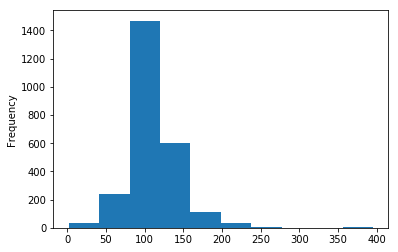

In [43]:
numeric_data['FTI'].plot.hist()

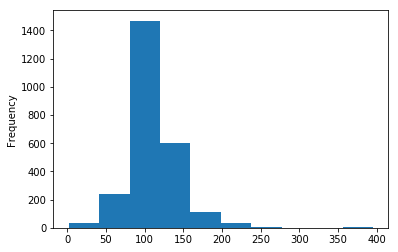

In [33]:
numeric_data['FTI'].dropna().plot.hist()

In [34]:
# z-normalization: shift = mean, scale = std
# 0-1 normalization: shift = min, scale =  max - min
# toto iste robi StandardScaler pre vsetky atributy. Pozor ale na power law
# ak pouzijete RobustScaler, tak si viete poradit aj s outliermi (pouziva rozsah 1st quartile (25th quantile) and the 3rd quartile (75th quantile))
def normalization(data, shift, scale): 
    return (np.array(data) - float(shift))/scale

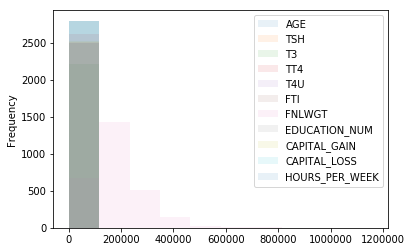

In [35]:
numeric_data.plot.hist(alpha=0.1)

In [36]:
data['TSH'].isna().sum()

284

# TSH

Text(0.5,1,'index: TSH (without box-cox)')

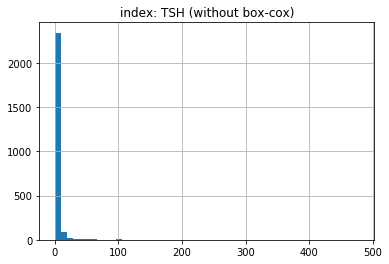

In [101]:
index = 'TSH'
transformed = data['TSH'].dropna()
pom = pd.Series(transformed).hist(bins=50)
pom.set_title(f"index: {index} (without box-cox)")

Text(0.5,1,'index: TSH (box-cox)')

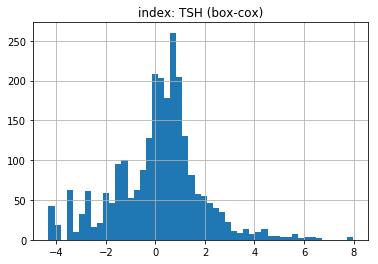

In [102]:
transformed, att = boxcox(data['TSH'].dropna())# boxcox vrati transformovane data a parametre transformacie. Tie viem zafixovat a v tom pripade mi to vrati len transformovane data
pom = pd.Series(transformed).hist(bins=50)
pom.set_title(f"index: {index} (box-cox)")

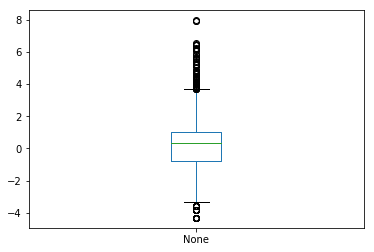

In [78]:
pd.Series(transformed).plot(kind='box')

Text(0.5,1,'throughput (Z-normalization)')

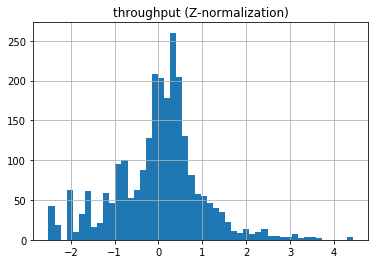

In [103]:
z_transformed = normalization(transformed, np.mean(transformed), np.std(transformed))
pom = pd.Series(z_transformed).hist(bins=50)
pom.set_title('throughput (Z-normalization)')

Text(0.5,1,'throughput (Z-normalization)')

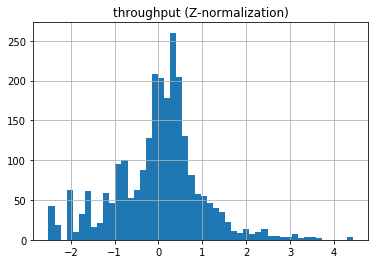

In [80]:
# sklearn.preprocessing
preprocessing.scale(transformed)
pom = pd.Series(z_transformed).hist(bins=50)
pom.set_title('throughput (Z-normalization)')

# T3

Text(0.5,1,'index: T3 (without box-cox)')

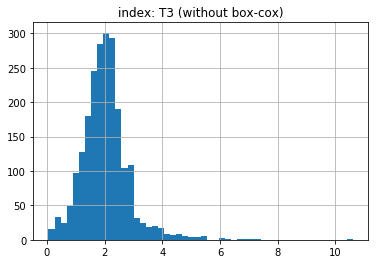

In [107]:
index = 'T3'
transformed = data['T3'].dropna()
pom = pd.Series(transformed).hist(bins=50)
pom.set_title(f"index: {index} (without box-cox)")

Text(0.5,1,'index: T3 (box-cox)')

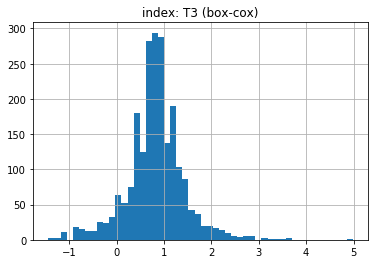

In [108]:
transformed, att = boxcox(data['T3'].dropna())# boxcox vrati transformovane data a parametre transformacie. Tie viem zafixovat a v tom pripade mi to vrati len transformovane data
pom = pd.Series(transformed).hist(bins=50)
pom.set_title(f"index: {index} (box-cox)")

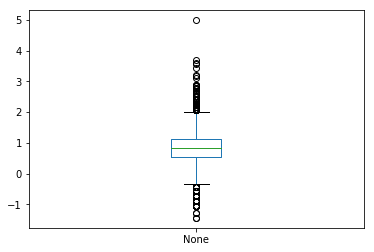

In [89]:
pd.Series(transformed).plot(kind='box')

# TT4

Text(0.5,1,'index: TT4 (without box-cox)')

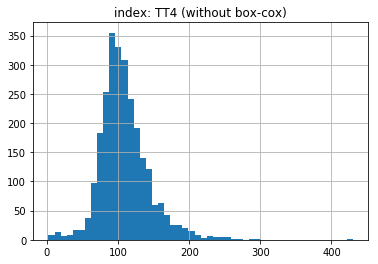

In [109]:
index = 'TT4'
transformed = data['TT4'].dropna()
pom = pd.Series(transformed).hist(bins=50)
pom.set_title(f"index: {index} (without box-cox)")

Text(0.5,1,'index: TT4 (box-cox)')

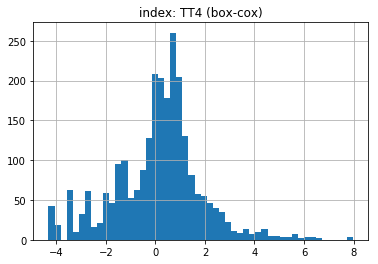

In [110]:
transformed, att = boxcox(data['TSH'].dropna())# boxcox vrati transformovane data a parametre transformacie. Tie viem zafixovat a v tom pripade mi to vrati len transformovane data
pom = pd.Series(transformed).hist(bins=50)
pom.set_title(f"index: {index} (box-cox)")

# Vychýlené hodnoty
V tejto časti sa snažíme spracovať vychýlené hodnoty numerických dát.

Atribút **age** odstránenie odchýlených hodnôt.

In [40]:
column = fixWierdCharsInString('age')
data[(data[column] < 1) | (data[column] > 100)]

,AGE,SEX,ON_THYROXINE,QUERY_ON_THYROXINE,ON_ANTITHYROID_MEDICATION,SICK,PREGNANT,THYROID_SURGERY,I131_TREATMENT,QUERY_HYPOTHYROID,...,CAPITAL_GAIN,CAPITAL_LOSS,HOURS_PER_WEEK,DATE_OF_BIRTH,JOB,STATE,MARITAL_STATUS,JOB_SEGMENT,RACE,CLASS
id,,,,,,,,,,,,,,,,,,,,,
685,455.0,FEMALE,False,False,False,False,False,False,False,False,...,0.0,0.0,40,NaT,SALES,UNITED_STATES,DIVORCED,PRIVATE,WHITE,NEGATIVE


# Chýbajúce hodnoty

Počty chýbajúcich hodnôt v jednotlivých atribútoch.
!!!http://scikit-learn.org/stable/data_transforms.html!!!

In [51]:
def count_missing(data):
    null_data = pd.isnull(data)
    null_count = np.sum(null_data)
    return (null_count)

In [52]:
def prop_missing(data):
    num = count_missing(data)
    dem = data.size
    return num/dem

In [53]:
def prop_complete(data):
    return 1 - prop_missing(data)

In [54]:
data.apply(count_missing)

AGE                            1
SEX                          110
ON_THYROXINE                   0
QUERY_ON_THYROXINE             0
ON_ANTITHYROID_MEDICATION      0
SICK                           0
PREGNANT                       0
THYROID_SURGERY                0
I131_TREATMENT                 0
QUERY_HYPOTHYROID              0
QUERY_HYPERTHYROID             0
LITHIUM                        0
GOITRE                         0
TUMOR                          0
HYPOPITUITARY                  0
PSYCH                          0
TSH_MEASURED                   0
TSH                          284
T3_MEASURED                    0
T3                           585
TT4_MEASURED                   0
TT4                          184
T4U_MEASURED                   0
T4U                          297
FTI_MEASURED                   0
FTI                          295
REFERRAL_SOURCE                0
FNLWGT                         0
EDUCATION                      0
EDUCATION_NUM                  0
RELATIONSH

In [55]:
#Vypiseme si kolko missign values maju riadky. Takze napriklad 0 missing values ma 1634 pacinetov
data.apply(count_missing, axis=1).value_counts()

0    1446
1     684
2     356
5     117
3     105
4      52
6      28
7       8
8       4
dtype: int64

In [56]:
data.dropna(how="all").shape # môžeme vidieť, že žiadny riadok nie je taký, že má všetky hodnoty chýbajúce.

(2800, 41)

## Odvodenie chýbajúcich hodnôt po riadkoch

Pre atribút **sex** vieme chýbajúcu hodnotu zistiť napríklad z atribútu **pregnant** alebo z atribútu **relationship**

In [57]:
data['SEX'].isna().sum()

110

In [58]:
# Vyfiltrujeme si pacientov s nešpecifikovaným pohlavím, ktorí sú tehotní.
column = fixWierdCharsInString('sex')
help_column = fixWierdCharsInString('pregnant')
data.loc[(data[column].isna()) & (data[help_column]), column] = 'F'
#data[(data[column].isna()) & (data[help_column])] = 'F'

In [59]:
data['SEX'].isna().sum()

109

In [60]:
help_column = fixWierdCharsInString('relationship')
# Neexistuje v datasete muž/žena, ktorý/ktorá je vydatý/oženená.
data.loc[data[data[column].isna() & (data[help_column] == fixWierdCharsInString('Wife'))].index, column] = 'F'
data.loc[data[data[column].isna() & (data[help_column] == fixWierdCharsInString('Husband'))].index, column] = 'M'
#data[data[column].isna() & (data[help_column] == fixWierdCharsInString('Wife'))]
#data[data[column].isna() & (data[help_column] == fixWierdCharsInString('Husband'))]

In [61]:
data['SEX'].isna().sum()

61

In [62]:
def calculateAgeFromDate(df, date_column, age_column):
    if df[data[date_column].notna()]:
        now = pd.Timestamp(dt.datetime.strp('01-01-2016'))
        df[date_column] = pd.to_datetime(df[date_column], format='%m%d%y')
        df[date_column] = df[date_column].where(df[date_column] < now, df[date_column] -  np.timedelta64(100, 'Y'))
        df[age_column] = (now - df[date_column]).astype('<m8[Y]')

In [63]:
def calculateDateFromAge(row):
    '2016'

In [64]:
age_column = fixWierdCharsInString('age')
date_column = fixWierdCharsInString('date_of_birth')
#data.apply(calculateAgeFromDate, args=(date_column, age_column,)) # = data[help_column].where(data[help_column] < now, data[help_column] -  np.timedelta64(100, 'Y'))
#data[column] = (now - data[help_column]).astype('timedelta64[Y]') 

## Doplnenie chýbajúcich hodnôt po stĺpcoch

Atribút **capital_gain** - chýbajúce hodnoty doplníme modusom, t.j. najčastejšie sa vyskytujúcou hodnotou.

In [65]:
checkAllObjectType(data)

SEX : 4
REFERRAL_SOURCE : 5
EDUCATION : 16
RELATIONSHIP : 6
JOB : 13
STATE : 36
MARITAL_STATUS : 7
JOB_SEGMENT : 8
RACE : 5
CLASS : 4


In [66]:
column = fixWierdCharsInString('capital_gain')
mode = data[column].mode()
data[column].fillna(int(data[column].mode()), inplace=True)

Polia, kde bola hodnota **'?'** sme prepísali na hodnotu **'Other_service'** z toho dôvodu, že tento atribút nevieme doplniť na základe žiadnej inej stratégie a preto sme priradili najvšeobecnejšiu hodnotu. 

In [67]:
column = fixWierdCharsInString('job')
data[column].value_counts()

ADM_CLERICAL         430
OTHER_SERVICE        400
PROF_SPECIALTY       382
EXEC_MANAGERIAL      355
SALES                316
CRAFT_REPAIR         202
MACHINE_OP_INSPCT    160
TECH_SUPPORT          84
TRANSPORT_MOVING      74
HANDLERS_CLEANERS     60
FARMING_FISHING       56
PROTECTIVE_SERV       51
PRIV_HOUSE_SERV       29
Name: JOB, dtype: int64

In [68]:
general_value = fixWierdCharsInString('Other_service')
data[column].fillna(general_value, inplace=True)
#data[column].replace(['?'], [general_value], inplace=True)
data[column].value_counts()

OTHER_SERVICE        601
ADM_CLERICAL         430
PROF_SPECIALTY       382
EXEC_MANAGERIAL      355
SALES                316
CRAFT_REPAIR         202
MACHINE_OP_INSPCT    160
TECH_SUPPORT          84
TRANSPORT_MOVING      74
HANDLERS_CLEANERS     60
FARMING_FISHING       56
PROTECTIVE_SERV       51
PRIV_HOUSE_SERV       29
Name: JOB, dtype: int64

Atribút **state** nahradíme modusom, pretože hodnota **'United_States'** sa nachádza u väčšiny pacientov a nevieme túto hodnotu doplniť pomocou iných atribútov. 

In [69]:
column = fixWierdCharsInString('state')
mode = data[column].mode()
data[column].fillna(mode, inplace=True)
#data[column].replace(['?'], [mode], inplace=True)

In [70]:
checkAllObjectType(data)

SEX : 4
REFERRAL_SOURCE : 5
EDUCATION : 16
RELATIONSHIP : 6
JOB : 13
STATE : 36
MARITAL_STATUS : 7
JOB_SEGMENT : 8
RACE : 5
CLASS : 4


# Pomocné grafové examples

- data.fillna((0: 1, 1:1, 2:1))
- data.isnull().sum()
- data.dropna(how='all')
- data.plot.box()

In [71]:
ts = pd.Series(np.random.randn(1000), index=pd.date_range('1/1/2000', periods=1000))

ts = ts.cumsum()
    
df = pd.DataFrame(np.random.randn(1000, 4), index=ts.index, columns=list('ABCD'))

df = df.cumsum()
df3 = pd.DataFrame(np.random.randn(1000, 2), columns=['B', 'C']).cumsum()

df3['A'] = pd.Series(list(range(len(df))))
df3.head()

,B,C,A
0,0.675466,-1.161533,0
1,0.121409,-0.424751,1
2,0.823228,-0.515830,2
3,1.316087,-1.932208,3
4,1.016223,-1.326007,4


In [62]:
df.head(2)#.plot.hist(); plt.axhline(0, color='g')


,A,B,C,D
2000-01-01,-0.798348,-0.530807,0.467689,1.499743
2000-01-02,-0.366910,-1.146406,0.468429,0.983705


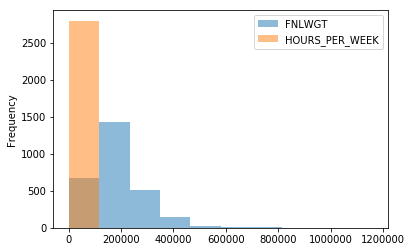

In [63]:
data.select_dtypes('int').plot.hist(alpha=0.5)

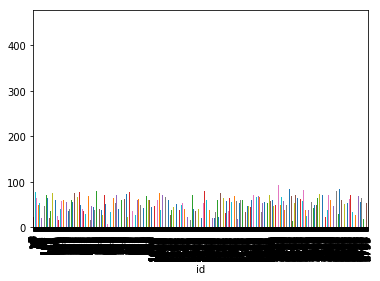

In [64]:
df2 = pd.DataFrame(np.random.rand(10, 4), columns=['a', 'b', 'c', 'd'])

#df2.plot.bar(stacked=True);
plt.figure()
data['AGE'].plot.bar()


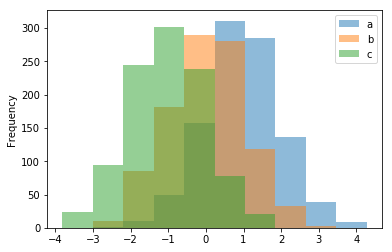

In [65]:
df4 = pd.DataFrame({'a': np.random.randn(1000) + 1, 'b': np.random.randn(1000),'c': np.random.randn(1000) - 1}, columns=['a', 'b', 'c'])
plt.figure();

df4.plot.hist(alpha=0.5)

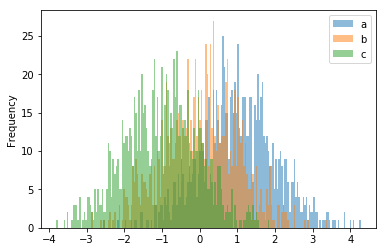

In [66]:
df4.plot.hist(alpha=0.5, bins=200)

In [67]:
plt.figure()
df['A'].head()

2000-01-01   -0.798348
2000-01-02   -0.366910
2000-01-03    0.389744
2000-01-04   -0.614466
2000-01-05   -0.318004
Freq: D, Name: A, dtype: float64

In [68]:
df['A'].diff().head()

2000-01-01         NaN
2000-01-02    0.431438
2000-01-03    0.756654
2000-01-04   -1.004210
2000-01-05    0.296461
Freq: D, Name: A, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a19541978>,
      dtype=object)

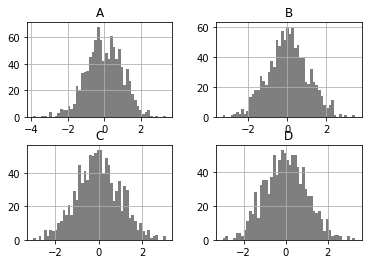

In [69]:
df.diff().hist(color='k', alpha=0.5, bins=50)

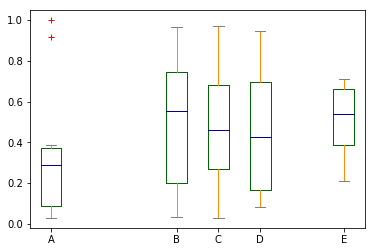

In [70]:
df = pd.DataFrame(np.random.rand(10, 5), columns=['A', 'B', 'C', 'D', 'E'])
color = dict(boxes='DarkGreen', whiskers='DarkOrange', medians='DarkBlue', caps='Gray')
df.plot.box(color=color, sym='r+', positions=[1, 4, 5, 6, 8])

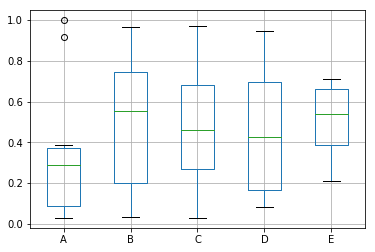

In [71]:
df.boxplot()

In [72]:
df = pd.DataFrame(np.random.rand(10,2), columns=['Col1', 'Col2'] )

df['X'] = pd.Series(['A','A','A','A','A','B','B','B','B','B'])

plt.figure();
df
#bp = df.boxplot(by='X')

,Col1,Col2,X
0,0.105600,0.117934,A
1,0.364070,0.092518,A
2,0.654015,0.257258,A
3,0.519685,0.463350,A
4,0.920638,0.186514,A
5,0.647009,0.851023,B
6,0.720494,0.491384,B
7,0.305490,0.630653,B
8,0.717478,0.958376,B
9,0.429479,0.666412,B


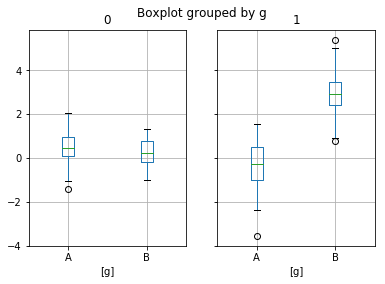

In [73]:
np.random.seed(1234)
df_box = pd.DataFrame(np.random.randn(50, 2))
df_box['g'] = np.random.choice(['A', 'B'], size=50)
df_box.loc[df_box['g'] == 'B', 1] += 3
bp = df_box.boxplot(by='g')

In [74]:
df = pd.DataFrame(np.random.rand(50, 4), columns=['a', 'b', 'c', 'd'])

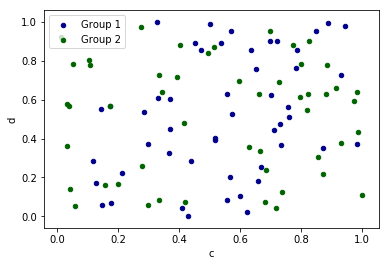

In [75]:
ax = df.plot.scatter(x='a', y='b', color='DarkBlue', label='Group 1');

df.plot.scatter(x='c', y='d', color='DarkGreen', label='Group 2', ax=ax);

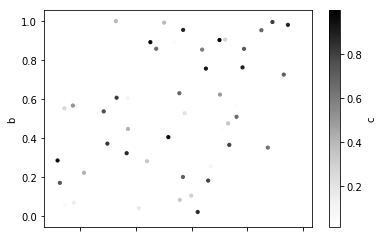

In [76]:
df.plot.scatter(x='a', y='b', c='c', s=10);

# Zdroje
Príklady ako pracovať s pandas - https://pandas.pydata.org/pandas-docs/stable/cookbook.html#cookbook-plotting

Robenie grafov v pandas - https://pandas.pydata.org/pandas-docs/stable/visualization.html

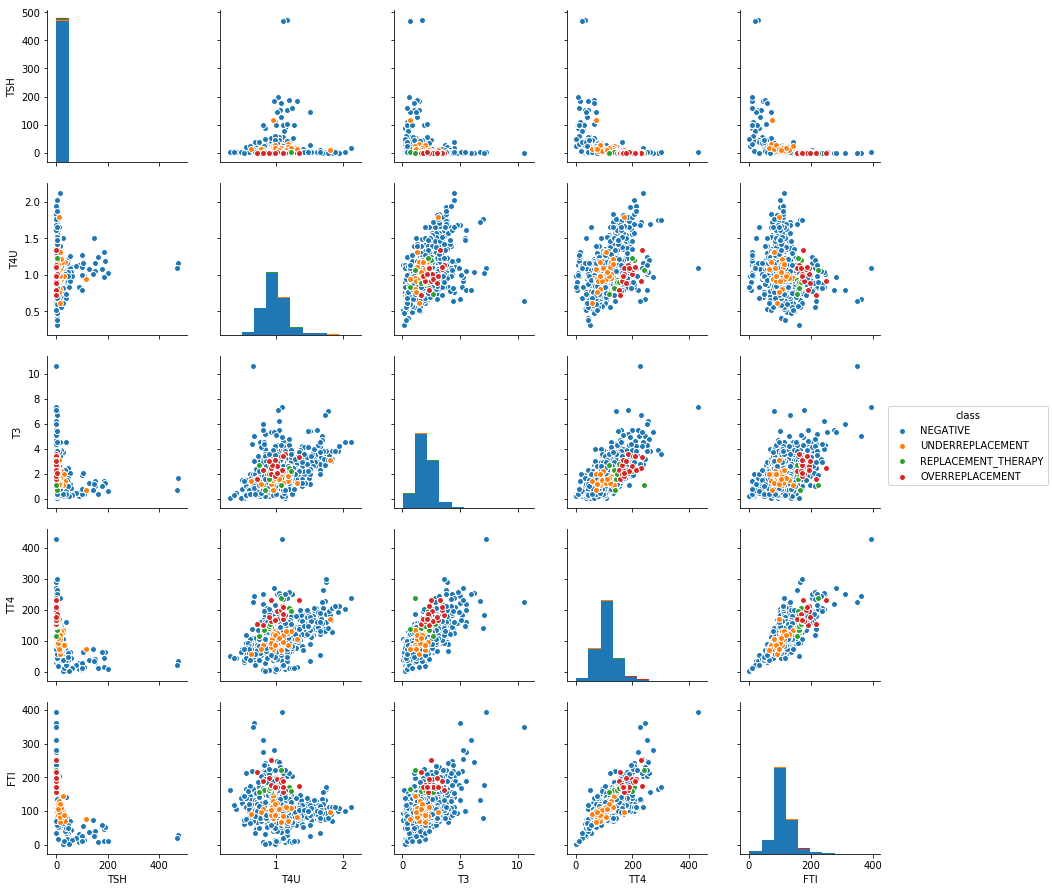

In [96]:
sample = data.dropna()
#seaborn.pairplot(sample.loc[:,['TSH', 'T4U', 'T3', 'TT4', 'unknown1']])
dataFrame = data.loc[:,['TSH', 'T4U', 'T3', 'TT4']]
dataFrame['FTI'] = pd.to_numeric(data['FTI'], errors='coerce')

column1_name = 'CLASS'

dataFrame['class'] = data['CLASS']
dataFrame = dataFrame.dropna()


seaborn.pairplot(dataFrame[dataFrame['class'] != 'negative'], dropna=True, hue='class')

In [162]:
data['CLASS'].value_counts()

NEGATIVE               2713
UNDERREPLACEMENT         35
REPLACEMENT_THERAPY      29
OVERREPLACEMENT          23
Name: CLASS, dtype: int64

In [594]:
df0 = data[(data['TSH'] < 0.2) & ((data['T4U'] < 1.1) & (data['T4U'] < 0.8))]
df0.shape

(44, 41)

In [595]:
df0['CLASS'].value_counts()

NEGATIVE               40
REPLACEMENT_THERAPY     3
OVERREPLACEMENT         1
Name: CLASS, dtype: int64

In [558]:
df1 = data[(data['FTI'] < 71) | (data['TT4'] < 72) | (data['T3'] > 3.6) | (data['T4U'] > 1.34)]
df1.shape

(420, 41)

In [559]:
df1['CLASS'].value_counts()

NEGATIVE            414
UNDERREPLACEMENT      6
Name: CLASS, dtype: int64

In [480]:
df2 = data[(data['T4U'] > 1.36)]

In [476]:
df2['CLASS'].value_counts()

NEGATIVE            111
UNDERREPLACEMENT      1
Name: CLASS, dtype: int64

In [265]:
df3 = data[(data['TSH'] > 80) | ((data['TSH'] < 1) & (data['T3'] > 3.6)) | ((data['TSH'] > 40) & (data['TSH'] < 75))]
df3.shape

(112, 41)

In [266]:
df3['CLASS'].value_counts()

NEGATIVE            111
UNDERREPLACEMENT      1
Name: CLASS, dtype: int64

In [386]:
df4 = data[(data['TSH'] < 37) & (data['T3'] > 3.4)]
df4.shape

(99, 41)

In [387]:
df4['CLASS'].value_counts()

NEGATIVE           98
OVERREPLACEMENT     1
Name: CLASS, dtype: int64

In [615]:
df5 = data[(data['FTI'] < 65)]
df5.shape

(90, 41)

In [616]:
df5['CLASS'].value_counts()

NEGATIVE    90
Name: CLASS, dtype: int64